# 这是一篇微信小程序游戏“最强弹一弹”预测小球运行轨迹的Notebook，将用到Computer Vision的一些技术，实现的过程是检测游戏中的可碰撞物体，然后根据获取到的数据预测球的运行轨迹

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
from PIL import Image
import traceback

%matplotlib inline

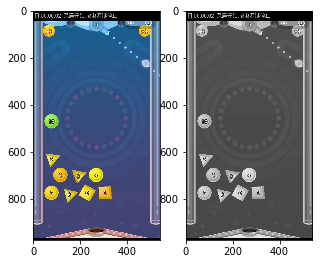

In [3]:
image = cv2.imread('images/game_1.png')

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
f,(ax1,ax2) = plt.subplots(1,2,figsize=(5,10))
ax1.imshow(image)
image_gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
ax2.imshow(image_gray,'gray')

上面是我随便取的一个游戏截图，由于游戏背景图对我们计算球的运行路线造成了干扰，所以我们首先要做的就是去除背景的干扰，至于怎么去除，我们可以先看看游戏截图在RGB和HSV各通道的灰度图像：

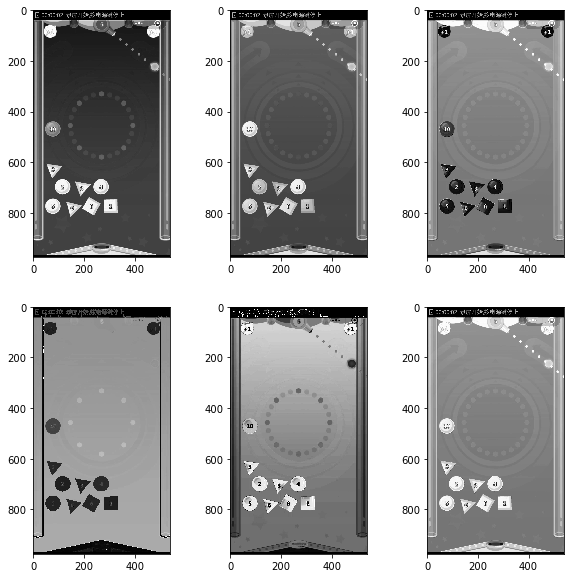

In [5]:
def show_rgbimage_rgbhsv(image):
    r = image[:,:,0]
    g = image[:,:,1]
    b = image[:,:,2]
    
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]
    
    f,axs = plt.subplots(2,3,figsize=(10,10))
    axs[0][0].imshow(r,cmap='gray')
    axs[0][1].imshow(g,cmap='gray')
    axs[0][2].imshow(b,cmap='gray')
    axs[1][0].imshow(h,cmap='gray')
    axs[1][1].imshow(s,cmap='gray')
    axs[1][2].imshow(v,cmap='gray')
show_rgbimage_rgbhsv(image)

从上图可以看出背景和前景的最大差别就是它的亮度(第二排第三列)，那我们只要设置一个亮度阈值把背景和数字去除即可：

In [6]:
# 输入图像，预测背景区域并返回
def get_bg_area(image):
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]

    background_area = v < 160
    return background_area

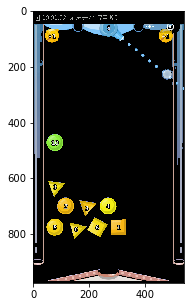

In [7]:
# 去除背景
image_copy = np.copy(image)
image_copy[get_bg_area(image)] = [0,0,0]

plt.figure(figsize=(10,5))
plt.imshow(image_copy)

将180（试验值）作为亮度阈值，成功的过滤掉背景图。下面我们获取图片中的实体对象，由于亮度通道的灰度图像中实体存在阴影会影响算法的判断，所以我们采用图像色彩通道的数据进行圆形筛选，采用霍夫变换算法：

In [8]:
# 将接近背景色（黑色）的物体颜色加深，以便算法识别
def change_color_close_to_black(image_one_color,bool_mat):
    for ii in range(len(image_one_color)):
        for jj in range(len(image_one_color[ii])):
            if not bool_mat[ii][jj] and image_one_color[ii][jj] < 70:            
                image_one_color[ii][jj] = 200

In [9]:
# 用霍夫算法抓取圆形
def find_circles(image,bg_area):
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    h = hsv[:,:,0]
    h[bg_area] = 0

    change_color_close_to_black(h,bg_area)
    # 采用高斯模糊后识别更精准一些
    gray_blur = cv2.GaussianBlur(h,(7,7),0)

    circles = cv2.HoughCircles(gray_blur, cv2.HOUGH_GRADIENT,1,
                              minDist=20,
                              param1=80,
                              param2=20,
                              minRadius=23,
                              maxRadius=44)
    return circles

In [10]:
def draw_circles(image,circles):
    if not type(circles) == np.ndarray:
        return
    circles = np.uint16(np.around(circles))

    for i in circles[0,:]:
        cv2.circle(image,(i[0],i[1]),i[2],(255,0,0),2)
        #cv2.circle(image,(i[0],i[1]),2,(255,0,0),10)

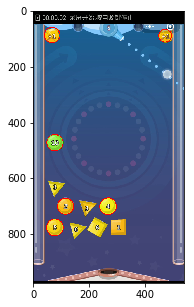

In [11]:
circles_im = np.copy(image)

background_area = get_bg_area(circles_im)
circles = find_circles(circles_im,background_area)
draw_circles(circles_im,circles)

plt.figure(figsize=(6,5))
plt.imshow(circles_im)


经过调整参数之后成功的获取到我们要的结果，右图中圆形实体被黑线框出，并点出圆心。

下面我们用opencv的threshold函数和findContours函数获取界面中的三角形和正方形：

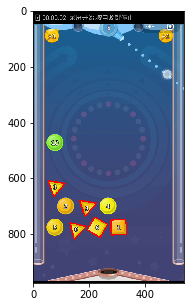

In [12]:
def crop_image(img_to_crop,dim=1):
    result = img_to_crop[111*dim:880*dim,42*dim:499*dim]
    return result

def crop_background(bg_area,dim=1):
    crop_bg = bg_area[111*dim:880*dim,42*dim:499*dim]
    return crop_bg

def findContours(crop_img_to_find,crop_bg_to_find):
    hsv = cv2.cvtColor(crop_img_to_find,cv2.COLOR_RGB2HSV)
    h = hsv[:,:,0]
    h[crop_bg_to_find] = 0
    h *= 8 # 加亮所有形状，除了背景

    change_color_close_to_black(h,crop_bg_to_find)

    ret,threshold_image = cv2.threshold(h,0,120,3)

    contours = cv2.findContours(threshold_image,2,4)
    return contours

def draw_trig_rect(crop_img,contours):
    for cnt in contours[1]:
        approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
        if len(approx)==3:
            cv2.drawContours(crop_img,[cnt],0,(255,0,0),3)
        elif len(approx)==4:
            cv2.drawContours(crop_img,[cnt],0,(255,0,0),3)

img = np.copy(image)            
crop_img = crop_image(img)
crop_bg = crop_background(background_area)
contours = findContours(crop_img,crop_bg)
draw_trig_rect(crop_img,contours)
plt.figure(figsize=(5,5))
plt.imshow(img)

上图最左是色彩通道的图像，右图是cv2.findContours函数获取到的三角形（绿色）和矩形（蓝色）形状。

有些实体不管怎么调参数都识别不了，可能是中间的数字影响了。我尝试了将数字去除，但是最终放弃了，数字的周边是渐变的颜色，我无法捕捉到规律完全地过滤它，高斯模糊也不起什么作用，总是会有一些残余的像素留下，影响效果。如果有更好的办法解决这个问题，望分享~

下面是计算发射瞄准点位置的函数，只用了二值化图像像素判断的土方法，真实应用中并不是个通用的算法，只是在特定情况下可用：

In [13]:
# 找出瞄准点的位置
center = (271,60) #发射器中心点
dist = 189 #寻找这个距离的瞄准点，再和中心点一起算出发射角度

def find_aim_center(image,bg_area):
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    v[bg_area] = 0

    ret,threshold_image = cv2.threshold(v,100,255,1)    
    
    first_point = None
    right_point = None
    y_point = None
    for y in range(130,200):
        for x in range(100,470):
            if not type(first_point) == list:
                if threshold_image[y][x] == 0:
                    first_point = [x,y]
                    break
    if not type(first_point) == list:
        return None,threshold_image
    
    for x in range(first_point[0],470):
        if threshold_image[first_point[1]][x] == 255:
            right_point = [x,first_point[1]]
            break
    if threshold_image[first_point[1]+1][first_point[0]] == 0:
        for y in range(first_point[1],180):
            if threshold_image[y][first_point[0]] == 255:
                y_point = [first_point[0],y]
                break
    else:
        for y in range(130,first_point[1]):
            y = first_point[1] - y
            if threshold_image[y][first_point[0]] == 255:
                y_point = [first_point[0],y]
                break

    aim_center = None
    if type(first_point) == list and type(right_point) == list and type(y_point) == list:
        aim_center = [int((first_point[0]+right_point[0])/2),int((first_point[1]+y_point[1])/2)]
    return aim_center,threshold_image

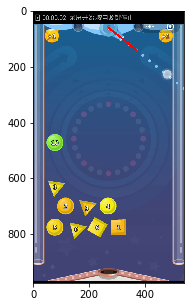

In [15]:
launch_im = np.copy(image)

background_area = get_bg_area(launch_im)
aim_point,thre = find_aim_center(launch_im,background_area)

cv2.line(launch_im,tuple(center),tuple(aim_point),[255,0,0],5)

plt.figure(figsize=(6,5))
plt.imshow(launch_im,'gray')

下面是读取视频，计算球运行轨迹，划线，并保存视频的代码。
对我来说真的是挺难的，涉及了中学物理和几何数学等知识，由于时间有限，最终也没有做好，只是对三角形的边界做了判断，其他的暂时没有时间做。

In [311]:
def trig_vertexs_to_lines(vertexs):
    lines = []
    for ii in range(len(vertexs)):
        if ii == len(vertexs) -1:
            temp = [0,0,0,0]
            temp[:2] = vertexs[ii]
            temp[2:] = vertexs[0]
            lines.append(temp)
        else:
            temp = [0,0,0,0]
            temp[:2] = vertexs[ii]
            temp[2:] = vertexs[ii+1]
            lines.append(temp)
    return  lines

def find_trig_vertexs(cnt):
    top,left,right,bottom = [],[],[],[]
    for c in cnt:
        c = c[0]
        if len(top) == 0:
            top = np.copy(c)
        if len(left) == 0:
            left = np.copy(c)
        if len(right) == 0:
            right = np.copy(c)
        if len(bottom) == 0:
            bottom = np.copy(c)
        if c[1] < top[1]:
            top = np.copy(c)
        if c[0] < left[0]:
            left = np.copy(c)
        if c[1] > bottom[1]:
            bottom = np.copy(c)
        if c[0] > right[0]:
            right = np.copy(c)
        
    if np.sum(top == left) == 2:
        return top,right,bottom
    elif np.sum(top == right) == 2:
        return top,left,bottom
    if np.sum(bottom == left) == 2:
        return top,right,bottom
    elif np.sum(bottom == right) == 2:
        return top,left,bottom
    
def find_touch_line(circle_center,lines):
    line_min = None
    d_min = 100
    for line in lines:
        w = (line[1]-line[3])/ (line[0]-line[2])
        b = line[1] - (line[0] * w)
        d = abs((w * circle_center[0] - circle_center[1] + b)/math.sqrt(pow(w,2)+1))
        if d < d_min:
            d_min = d
            line_min = line
        #print(str(d))
        
    #print(circle_center)
    #print(line)
    #print(d)
    if d_min > 12:
        return None
    return line_min

def is_legal_trig_vers(vers):
    for ii in range(len(vers)):
        if ii == len(vers) -1:
            if pow(vers[ii][0] - vers[0][0],2) + pow(vers[ii][1] - vers[0][1],2) < 120:
                return False
        else:
            if pow(vers[ii][0] - vers[ii+1][0],2) + pow(vers[ii][1] - vers[ii+1][1],2) < 120:
                return False
    return True
            

In [326]:
# 读取视频
show_img = np.zeros_like(image)
video = cv2.VideoCapture('images/game_video.mp4')

fps = 41 
size = (540,976)  

videoWriter = cv2.VideoWriter('out.avi', -1 , fps, size) 

cv2.namedWindow('video')
#cv2.namedWindow('Threshold')
#cv2.namedWindow('test')

init_speed = 5
gravity = 0.032
# 球发射起点距离发射中心点的位置
dist_launch_point = 64.846
# 球半径
ridius_ball = 12
# 右边缘线
edge_right = 490 - ridius_ball
# 左边缘线
edge_left = 42 + ridius_ball

#碰撞后速度损失
speed_loss = 0.5

jump_frame = 100
frame_count = 0

dont_show_line_after_frame_number = 270

try:
    while video.isOpened():
        ret,frame = video.read()
        if not ret:
            break
        frame_count += 1
        if frame_count < jump_frame:
            continue
        
        
        crop_img = crop_image(frame,1)
        bg_area = get_bg_area(frame)
        crop_bg = crop_background(bg_area,1)
        contours = findContours(crop_img,crop_bg)
        circles = find_circles(crop_img,bg_area=crop_bg)
        

        if frame_count < dont_show_line_after_frame_number:
            aim_point,thre = find_aim_center(frame,bg_area)
            if type(aim_point) == list:
                # draw trajectory

                # calculate speed
                dx = aim_point[0] - center[0]
                dy = aim_point[1] - center[1]
                t = math.atan(dy/dx)
                speed = [init_speed*math.cos(t),init_speed*math.sin(t)]

                start_point = [center[0]+int(dist_launch_point*math.cos(t)),center[1]+int(dist_launch_point*math.sin(t))]

                start_x,start_y = start_point[0],start_point[1]
                jump_unit = 3
                
                for y in range(start_point[1],330,jump_unit):
                    next_x = int(start_x + speed[0] * jump_unit)

                    next_y = int(start_y + speed[1] * jump_unit)

                    speed = [speed[0],speed[1]+gravity*jump_unit]

                    dx = next_x - start_x
                    dy = next_y - start_y
                    t = 999999
                    if not dx == 0:
                        t = math.atan(dy/dx)

                    if next_x >= edge_right:
                        # energy loss, just cal speed loss
                        speed = [-abs(speed[0])+ abs(math.cos(t)*speed_loss),speed[1]]
                        #speed = [-abs(speed[0]),speed[1]]
                    elif next_x <= edge_left:
                        speed = [abs(speed[0]) - abs(math.cos(t)*speed_loss),speed[1]]
                        #speed = [abs(speed[0]),speed[1]]
                    else:
                        for cnt in contours[1]:
                            approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
                            if not len(approx) == 3:
                                continue
                            vers = find_trig_vertexs(cnt)
                            if None == vers:
                                continue

                            if not is_legal_trig_vers(vers):
                                continue
                            for ver in vers:
                                ver[0] += 42
                                ver[1] += 111
                                
                            trig_center = [(vers[0][0]+vers[1][0]+vers[2][0])/3,(vers[0][1]+vers[1][1]+vers[2][1])/3]
                            #cv2.circle(frame,(42+int(vers[0][0]),111+int(vers[0][1])),2,(255,255,0),20)
                            #cv2.circle(frame,(42+int(vers[1][0]),111+int(vers[1][1])),2,(255,255,0),20)
                            #cv2.circle(frame,(42+int(vers[2][0]),111+int(vers[2][1])),2,(255,255,0),20)
                            #cv2.circle(frame,(int(trig_center[0]),int(trig_center[1])),2,(255,255,0),20)

                            if abs(next_y - trig_center[1]) < 30 and abs(next_x - trig_center[0]) < 30:
                                lines = trig_vertexs_to_lines(vers)
                                line = find_touch_line([next_x,next_y],lines)
                                if None == line:
                                    continue
                                cv2.line(frame,(line[0],line[1]),(line[2],line[3]),(255,255,0),10)
                                
                                k1 = (line[1]-line[3])/(line[0]-line[2])
                                k2 = speed[1]/speed[0]
                                # math.atan(|k1-k2|/|1+k1k2|) 已知两线斜率求夹角
                                t = math.atan(abs(k1-k2)/abs(1+k1*k2))
                                while t < 0:
                                    t += math.pi /4
                                while t > math.pi /4:
                                    t -= math.pi /4

                                speed_v = math.sqrt(pow(speed[0],2)+pow(speed[1],2))
                                speed_trans = [speed_v * math.cos(t),speed_v * math.sin(t)]

                                # 将速度转化为当前坐标系速度
                                angle_line = math.atan(abs(k1))
                                angle_speed_trans = angle_line + t

                                s1 = speed_trans[0]*math.cos(angle_speed_trans)
                                s2 = speed_trans[1]*math.sin(angle_speed_trans)
                                
                                if k2 >0 :
                                    if speed[0] < 0:
                                        s1 = -abs(s1)
                                        s2 = -abs(s2)
                                    else:
                                        s1 = abs(s1)
                                        s2 = -abs(s2)
                                else:
                                    if speed[0] < 0:
                                        s1 = -abs(s1)
                                        s2 = -abs(s2)
                                    else:
                                        s1 = -abs(s1)
                                        s2 = -abs(s2)
                                speed = [s1,s2]
                                break
                            

                    #cv2.line(frame,(start_x,start_y),(next_x,next_y),[255,0,0],3)
                    cv2.circle(frame,(next_x,next_y),2,(255,255,0),2)
                    
                    start_x = next_x
                    start_y = next_y

        draw_trig_rect(crop_img,contours)
        draw_circles(crop_img,circles)

        cv2.imshow('video',frame)
        #cv2.imshow('test',thre)
        videoWriter.write(frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
except Exception as err:
    traceback.print_exc()
    
finally:
    video.release()
    videoWriter.release()
cv2.destroyAllWindows()

In [25]:
#获取某一帧图像
video = cv2.VideoCapture('images/game_video.mp4')
for ii in range(0,282):
    ret,frame = video.read()
video.release()
cv2.imwrite('images/game_2.png',frame)

True

In [16]:
#读取手机截图，再显示出来，一两秒才能截图1次，实在太慢了
'''
import os

cv2.namedWindow('Cap')
cv2.namedWindow('Threshold')
while True:
    os.system('adb shell screencap -p /sdcard/test.png')
    os.system('adb pull /sdcard/test.png')
    cap = cv2.imread('test.png')
    
    crop_img = crop_image(cap,2)
    crop_bg = crop_background(get_bg_area(cap),2)
    thresh,contours = findContours(crop_img,crop_bg)
    draw_trig_rect(crop_img,contours)
    cap = cv2.resize(cap,(540,960),interpolation=cv2.INTER_CUBIC)
    thresh = cv2.resize(thresh,(540,960),interpolation=cv2.INTER_CUBIC)
    cv2.imshow('Cap',cap)
    cv2.imshow('Threshold',thresh)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
'''

"\nimport os\n\ncv2.namedWindow('Cap')\ncv2.namedWindow('Threshold')\nwhile True:\n    os.system('adb shell screencap -p /sdcard/test.png')\n    os.system('adb pull /sdcard/test.png')\n    cap = cv2.imread('test.png')\n    \n    crop_img = crop_image(cap,2)\n    crop_bg = crop_background(get_bg_area(cap),2)\n    thresh,contours = findContours(crop_img,crop_bg)\n    draw_trig_rect(crop_img,contours)\n    cap = cv2.resize(cap,(540,960),interpolation=cv2.INTER_CUBIC)\n    thresh = cv2.resize(thresh,(540,960),interpolation=cv2.INTER_CUBIC)\n    cv2.imshow('Cap',cap)\n    cv2.imshow('Threshold',thresh)\n    if cv2.waitKey(1) & 0xFF == ord('q'):\n        break\n\ncv2.destroyAllWindows()\n"